In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [3]:
class Maximize(object):
    period = 30

    
    def __init__(self, n, rho, gamma):
        self.n = n
        self.rho = rho
        self.gamma = gamma
        
        
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.hc_ = self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_

        
    def get_original_H(self, hc_mu, hc_sigma):
        dc_rate = np.exp((0.04 + 0.04 + 0.0) * (np.array(range(self.period)) + 1) * (-1))
        
        if self.period == 0:
            self.labor_income = np.zeros([self.n, self.period+1])
            self.H_t = np.zeros([self.n])
        else:
            self.labor_income = self.initial_income*np.cumprod(np.exp(hc_mu+hc_sigma*(self.rho * self.market_[:, :-1] + np.sqrt(1 - self.rho ** 2) * self.hc_[:, :-1])), axis=1)
            self.H_t = self.labor_income @ dc_rate
    
    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
    
    
    def fit(self):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)

            if self.gamma == 1:
                obj = np.log(W_t+self.H_t) * (-1)
            else:
                obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                {'type': 'ineq', 'fun': lambda x: x},)
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons)
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income

34 [100.   0.] 1000 2375.0
33 [100.   0.] 2228.0 2497.0
32 [100.   0.] 3847.0 2625.0
31 [100.   0.] 5989.0 2760.0
30 [100.   0.] 8754.0 2902.0
29 [100.   0.] 12294.0 3051.0
28 [100.   0.] 16910.0 3208.0
27 [100.   0.] 22834.0 3373.0
26 [100.   0.] 30431.0 3546.0
25 [99.61  0.39] 40204.0 3728.0
24 [86.51 13.49] 52808.0 3920.0
23 [74.94 25.06] 67284.0 4121.0
22 [70.88 29.12] 83351.0 4333.0
21 [64.83 35.17] 102321.0 4556.0
20 [62.94 37.06] 123637.0 4789.0
19 [57.63 42.37] 148809.0 5035.0
18 [54.72 45.28] 176832.0 5293.0
17 [53.39 46.61] 208447.0 5565.0
16 [51.39 48.61] 245012.0 5851.0
15 [51.76 48.24] 286338.0 6151.0
14 [47.71 52.29] 335034.0 6467.0
13 [48.67 51.33] 387394.0 6798.0
12 [47.6 52.4] 449791.0 7148.0
11 [45.7 54.3] 522112.0 7515.0
10 [45.35 54.65] 601396.0 7901.0
9 [45.07 54.93] 693240.0 8306.0
8 [45.01 54.99] 798593.0 8734.0
7 [42.28 57.72] 918903.0 9182.0
6 [42.93 57.07] 1049762.0 9653.0
5 [42.49 57.51] 1202187.0 10148.0
4 [41.88 58.12] 1372452.0 10668.0
3 [43.36 56.64] 1565

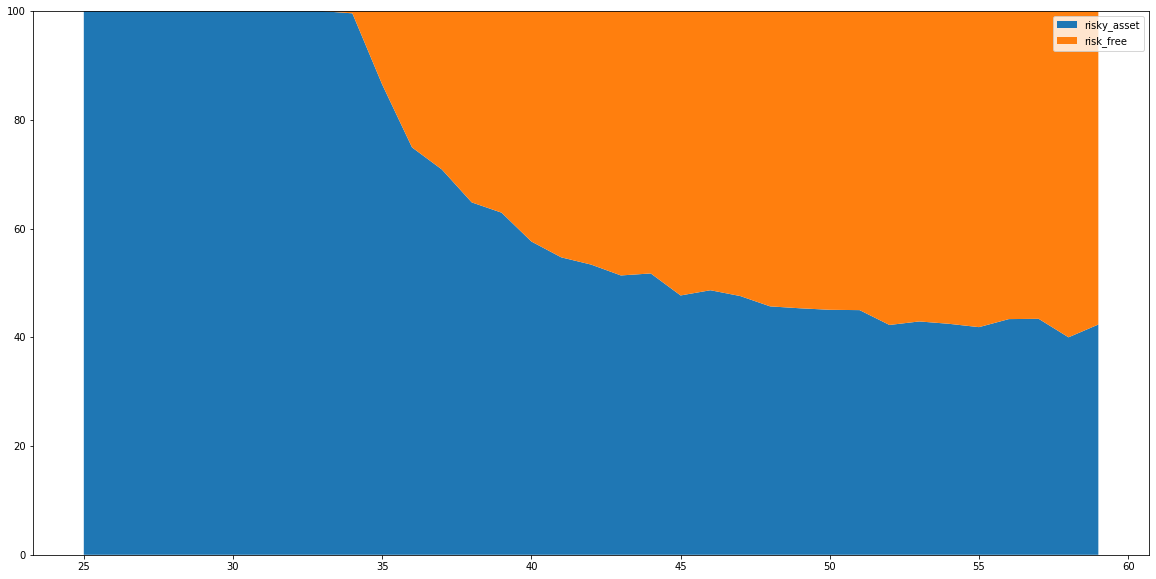

In [4]:
np.random.seed(30)

lc_weights = []
model = Maximize(n=20000, rho=0.633465, gamma=4)
for i in range(35)[::-1]:
    
    if i is range(35)[::-1][0]:
        financial_wealth = 1000
        income = np.exp(7.5072-0.7417+0.3198+0.059*2 + 25 * 0.0124 + ((25**2 /10) *0.0064) + ((25**3/100) * -0.0009))
        model.change_parameters(i, financial_wealth, income)
    else:
        financial_wealth = (model.initial_wealth + np.mean(model.labor_income[:, 0]) * 0.3) * np.mean(model.R_t @ model.fit())
        income = np.mean(model.labor_income[:, 0])
        model.change_parameters(i, financial_wealth, income)

    model.MC_data()
    model.get_original_H(hc_mu=0.05, hc_sigma=0.01)
    model.get_asset_ret(market_mu=0.12, market_sigma=0.35, rf_mu=0.04, rf_sigma=0.03)
    opt_weights = model.fit()
    lc_weights.append(opt_weights)
    print(model.period, opt_weights * 100, np.round(financial_wealth), np.round(income))
    #print(model.period, model.fit() * 100, np.round(model.initial_wealth), np.round(np.mean(model.labor_income[:, 0])))

lc_df = pd.DataFrame(lc_weights, columns=["risky_asset", "risk_free"]) * 100

plt.figure(figsize=(20, 10))
plt.fill_between(lc_df.index+25, lc_df["risky_asset"])
plt.fill_between(lc_df.index+25, lc_df["risky_asset"], 100)
plt.legend(["risky_asset", "risk_free"])
plt.ylim(0, 100)
plt.show()

In [5]:
class Maximize_Calibraton(object):
    period = 30
    #np.random.seed(period)
    retirement_age = 60

    
    def __init__(self, n, rho, gamma, aggregate_risk):
        self.n = n
        self.rho = rho
        self.gamma = gamma
        self.aggregate_risk = aggregate_risk
        
            
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.hc_ = self.aggregate_risk*(self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_)


    def get_calibration_H(self, fixed_effect_coeff, age_coeff_list):
        dc_rate = np.exp((0.04 + 0.04 + 0.0) * (np.array(range(self.period+1)) + 1) * (-1))
        age_list = np.array(list(range(self.retirement_age-(self.period+1), self.retirement_age)))

        after_retire_H_t = np.exp(fixed_effect_coeff) / (1-dc_rate[0])
        if self.period == 0:
            self.labor_income = np.exp(fixed_effect_coeff)
            self.H_t = after_retire_H_t
        else:
            ic_list = fixed_effect_coeff + (age_list * age_coeff_list[0]) + ((age_list**2 /10) * age_coeff_list[1]) + ((age_list**3/100) * age_coeff_list[2])
            self.labor_income = np.exp(np.array([ic_list]*self.n)  + self.hc_[:, :-1])
            self.H_t = self.labor_income @ dc_rate + (after_retire_H_t * dc_rate[-1])

    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
    
    
    def fit(self):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)

            if self.gamma == 1:
                obj = np.log(W_t+self.H_t) * (-1)
            else:
                obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                {'type': 'ineq', 'fun': lambda x: x},)
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons)
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income, retirement_age=60):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income
        self.retirement_age = retirement_age

34 [100.   0.] 1000 2375.0
33 [100.   0.] 2265.0 2595.0
32 [100.   0.] 3900.0 2664.0
31 [76.76 23.24] 6031.0 2752.0
30 [62.18 37.82] 8409.0 2834.0
29 [52.21 47.79] 10981.0 2889.0
28 [45.16 54.84] 13813.0 2984.0
27 [40.65 59.35] 16892.0 3066.0
26 [35.87 64.13] 20283.0 3148.0
25 [34.74 65.26] 23898.0 3223.0
24 [31.95 68.05] 27926.0 3291.0
23 [28.76 71.24] 32314.0 3387.0
22 [28.57 71.43] 36952.0 3464.0
21 [27.26 72.74] 42139.0 3559.0
20 [25.39 74.61] 47816.0 3618.0
19 [23.75 76.25] 53857.0 3700.0
18 [23.65 76.35] 60285.0 3769.0
17 [22.29 77.71] 67393.0 3861.0
16 [21.54 78.46] 74983.0 3929.0
15 [21.61 78.39] 83172.0 4006.0
14 [20.56 79.44] 92148.0 4071.0
13 [20.11 79.89] 101837.0 4147.0
12 [20.1 79.9] 112256.0 4198.0
11 [19.26 80.74] 123687.0 4259.0
10 [19.22 80.78] 135763.0 4312.0
9 [18.42 81.58] 148912.0 4361.0
8 [18.77 81.23] 162900.0 4408.0
7 [18.04 81.96] 178253.0 4446.0
6 [17.75 82.25] 194535.0 4444.0
5 [17.9 82.1] 212228.0 4486.0
4 [17.36 82.64] 231365.0 4496.0
3 [17.34 82.66] 25198

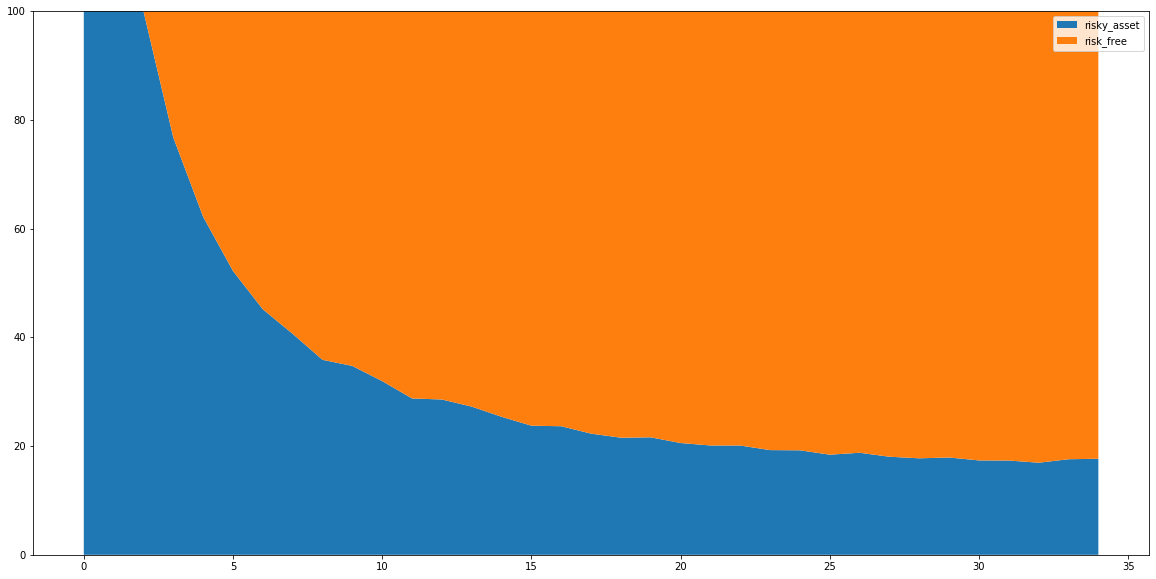

In [24]:
np.random.seed(30)

lc_weights = []
model = Maximize_Calibraton(n=20000, rho=0.633465, gamma=10, aggregate_risk=np.sqrt(0.174855+0.005461))
for i in range(35)[::-1]:
    
    if i is range(35)[::-1][0]:
        financial_wealth = 1000
        income = np.exp(7.5072-0.7417+0.3198+0.059*2 + 25 * 0.0124 + ((25**2 /10) *0.0064) + ((25**3/100) * -0.0009))
        model.change_parameters(i, financial_wealth, income)
    else:
        financial_wealth = (model.initial_wealth + np.mean(model.labor_income[:, 0]) * 0.3) * np.mean(model.R_t @ model.fit())
        income = np.mean(model.labor_income[:, 0])
        model.change_parameters(i, financial_wealth, income)

    model.MC_data()
    model.get_calibration_H(fixed_effect_coeff=[7.5072-0.7417+0.3198+0.059*2], age_coeff_list=[0.0124, 0.0064, -0.0009])
    model.get_asset_ret(market_mu=0.12, market_sigma=0.35, rf_mu=0.04, rf_sigma=0.03)
    opt_weights = model.fit()
    lc_weights.append(opt_weights)
    print(model.period, opt_weights * 100, np.round(financial_wealth), np.round(income))
    #print(model.period, model.fit() * 100, np.round(model.initial_wealth), np.round(np.mean(model.labor_income[:, 0])))

lc_df = pd.DataFrame(lc_weights, columns=["risky_asset", "risk_free"]) * 100

plt.figure(figsize=(20, 10))
plt.fill_between(lc_df.index, lc_df["risky_asset"])
plt.fill_between(lc_df.index, lc_df["risky_asset"], 100)
plt.legend(["risky_asset", "risk_free"])
plt.ylim(0, 100)
plt.show()

34 [100.   0.] 1000 2636.0
33 [100.   0.] 2361.0 2845.0
32 [100.   0.] 4141.0 2977.0
31 [100.   0.] 6482.0 3126.0
30 [100.   0.] 9526.0 3267.0
29 [100.   0.] 13386.0 3377.0
28 [100.   0.] 18403.0 3527.0
27 [100.   0.] 24845.0 3659.0
26 [93.17  6.83] 33151.0 3787.0
25 [83.68 16.32] 43154.0 3908.0
24 [74.19 25.81] 54802.0 4013.0
23 [66.97 33.03] 68098.0 4150.0
22 [64.6 35.4] 82938.0 4267.0
21 [60.42 39.58] 100460.0 4394.0
20 [56.79 43.21] 120634.0 4469.0
19 [53.15 46.85] 143204.0 4585.0
18 [52.28 47.72] 168348.0 4675.0
17 [50. 50.] 197585.0 4795.0
16 [48.44 51.56] 230457.0 4885.0
15 [48.19 51.81] 267722.0 4984.0
14 [46.6 53.4] 310700.0 5072.0
13 [45.67 54.33] 359779.0 5158.0
12 [45.91 54.09] 415008.0 5235.0
11 [44.29 55.71] 479357.0 5312.0
10 [44.7 55.3] 550252.0 5402.0
9 [43.01 56.99] 632345.0 5473.0
8 [43.89 56.11] 723649.0 5555.0
7 [42.84 57.16] 829911.0 5624.0
6 [42.44 57.56] 948090.0 5657.0
5 [42.89 57.11] 1084253.0 5729.0
4 [42.16 57.84] 1239005.0 5800.0
3 [42.17 57.83] 1416132.0 5

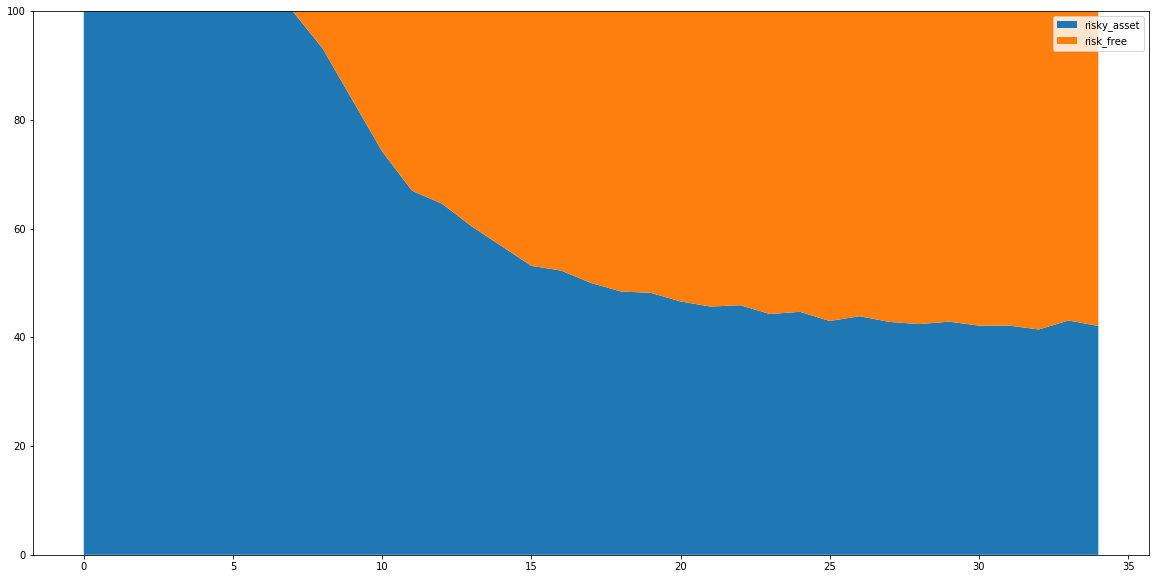

In [72]:
np.random.seed(30)

lc_weights = []
model = Maximize_Calibraton(n=20000, rho=0.334903, gamma=4, aggregate_risk=np.sqrt(0.145682+0.010166))
for i in range(35)[::-1]:
    
    if i is range(35)[::-1][0]:
        financial_wealth = 1000
        income = np.exp(7.8016-2.3326+0.2550+0.0537*2 + 25 * 0.1232 + ((25**2 /10) *-0.0193) + ((25**3/100) * 0.0011))
        model.change_parameters(i, financial_wealth, income)
    else:
        financial_wealth = (model.initial_wealth + np.mean(model.labor_income[:, 0]) * 0.3) * np.mean(model.R_t @ model.fit())
        income = np.mean(model.labor_income[:, 0])
        model.change_parameters(i, financial_wealth, income)

    model.MC_data()
    model.get_calibration_H(fixed_effect_coeff=[7.8016-2.3326+0.2550+0.0537*2], age_coeff_list=[0.1232, -0.0193, 0.0011])
    model.get_asset_ret(market_mu=0.12, market_sigma=0.35, rf_mu=0.04, rf_sigma=0.03)
    opt_weights = model.fit()
    lc_weights.append(opt_weights)
    print(model.period, opt_weights * 100, np.round(financial_wealth), np.round(income))
    #print(model.period, model.fit() * 100, np.round(model.initial_wealth), np.round(np.mean(model.labor_income[:, 0])))

lc_df = pd.DataFrame(lc_weights, columns=["risky_asset", "risk_free"]) * 100

plt.figure(figsize=(20, 10))
plt.fill_between(lc_df.index, lc_df["risky_asset"])
plt.fill_between(lc_df.index, lc_df["risky_asset"], 100)
plt.legend(["risky_asset", "risk_free"])
plt.ylim(0, 100)
plt.show()

34 [100.   0.] 1000 2974.0
33 [100.   0.] 7105.0 15263.0
32 [100.   0.] 15170.0 16043.0
31 [100.   0.] 25837.0 16917.0
30 [100.   0.] 39787.0 17767.0
29 [100.   0.] 57574.0 18468.0
28 [100.   0.] 80754.0 19366.0
27 [100.   0.] 110598.0 20183.0
26 [100.   0.] 149148.0 20968.0
25 [95.07  4.93] 198178.0 21736.0
24 [82.04 17.96] 258543.0 22397.0
23 [72.87 27.13] 327463.0 23232.0
22 [69.1 30.9] 404585.0 23975.0
21 [63.89 36.11] 495554.0 24710.0
20 [59.56 40.44] 600322.0 25154.0
19 [55.32 44.68] 717619.0 25850.0
18 [54.03 45.97] 848278.0 26365.0
17 [51.42 48.58] 1000097.0 27020.0
16 [49.6 50.4] 1170769.0 27505.0
15 [49.15 50.85] 1364195.0 28016.0
14 [47.34 52.66] 1587161.0 28412.0
13 [46.28 53.72] 1841498.0 28726.0
12 [46.4 53.6] 2127590.0 29040.0
11 [44.7 55.3] 2460657.0 29240.0
10 [45.06 54.94] 2827547.0 29569.0
9 [43.27 56.73] 3252305.0 29672.0
8 [44.14 55.86] 3724311.0 29852.0
7 [43.05 56.95] 4273697.0 29857.0
6 [42.59 57.41] 4884520.0 29692.0
5 [43.04 56.96] 5587775.0 29573.0
4 [42.3 57

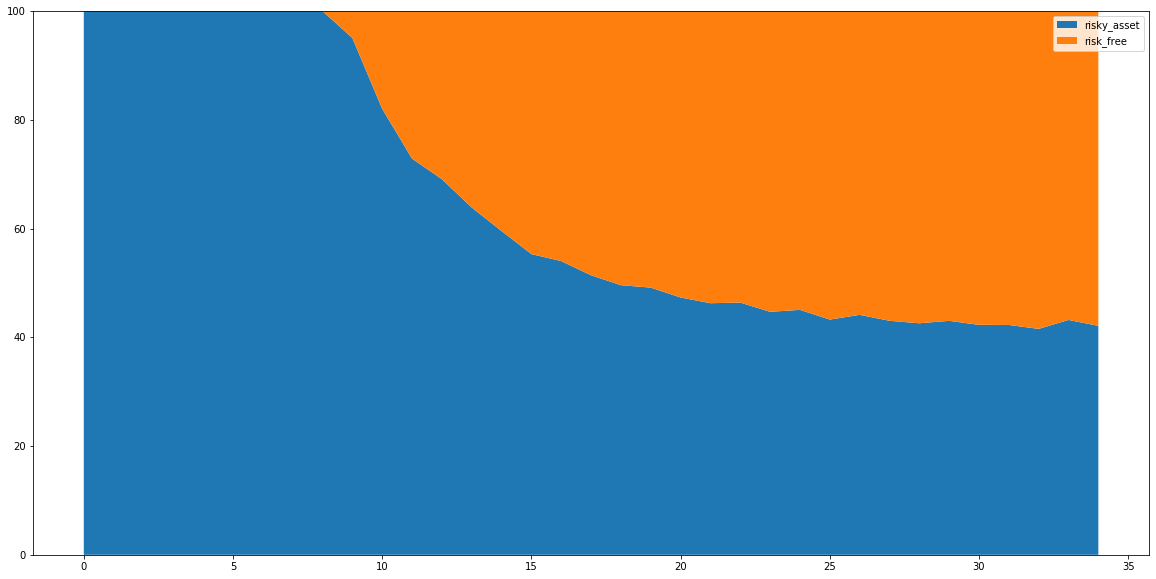

In [84]:
np.random.seed(30)

lc_weights = []
model = Maximize_Calibraton(n=20000, rho=-0.010961, gamma=4, aggregate_risk=np.sqrt(0.141262+0.005379))
for i in range(35)[::-1]:
    
    if i is range(35)[::-1][0]:
        financial_wealth = 1000
        income = np.exp(7.8717-2.3055+0.3841+0.0440*2 + 25 * 0.1055 + ((25**2 /10) *-0.0111) + ((25**3/100) * 0.0001))
        model.change_parameters(i, financial_wealth, income)
    else:
        financial_wealth = (model.initial_wealth + np.mean(model.labor_income[:, 0]) * 0.3) * np.mean(model.R_t @ model.fit())
        income = np.mean(model.labor_income[:, 0])
        model.change_parameters(i, financial_wealth, income)

    model.MC_data()
    model.get_calibration_H(fixed_effect_coeff=[7.8717-0.7417+0.3841+0.0440*2], age_coeff_list=[0.1055, -0.0111, 0.0001])
    model.get_asset_ret(market_mu=0.12, market_sigma=0.35, rf_mu=0.04, rf_sigma=0.03)
    opt_weights = model.fit()
    lc_weights.append(opt_weights)
    print(model.period, opt_weights * 100, np.round(financial_wealth), np.round(income))
    #print(model.period, model.fit() * 100, np.round(model.initial_wealth), np.round(np.mean(model.labor_income[:, 0])))

lc_df = pd.DataFrame(lc_weights, columns=["risky_asset", "risk_free"]) * 100

plt.figure(figsize=(20, 10))
plt.fill_between(lc_df.index, lc_df["risky_asset"])
plt.fill_between(lc_df.index, lc_df["risky_asset"], 100)
plt.legend(["risky_asset", "risk_free"])
plt.ylim(0, 100)
plt.show()

34 [100.   0.] 7000 2974.0
33 [100.   0.] 14747.0 15263.0
32 [100.   0.] 24896.0 16043.0
31 [100.   0.] 38250.0 16917.0
30 [100.   0.] 55632.0 17767.0
29 [100.   0.] 77700.0 18468.0
28 [100.   0.] 106396.0 19366.0
27 [100.   0.] 143267.0 20183.0
26 [94.74  5.26] 190835.0 20968.0
25 [84.57 15.43] 248844.0 21736.0
24 [74.81 25.19] 316262.0 22397.0
23 [67.65 32.35] 393201.0 23232.0
22 [64.98 35.02] 479270.0 23975.0
21 [60.73 39.27] 580713.0 24710.0
20 [57.1 42.9] 697521.0 25154.0
19 [53.4 46.6] 828299.0 25850.0
18 [52.44 47.56] 973980.0 26365.0
17 [50.14 49.86] 1143244.0 27020.0
16 [48.56 51.44] 1333555.0 27505.0
15 [48.26 51.74] 1549280.0 28016.0
14 [46.65 53.35] 1797921.0 28412.0
13 [45.71 54.29] 2081753.0 28726.0
12 [45.9 54.1] 2401082.0 29040.0
11 [44.29 55.71] 2772808.0 29240.0
10 [44.71 55.29] 3182320.0 29569.0
9 [43.02 56.98] 3656488.0 29672.0
8 [43.89 56.11] 4183756.0 29852.0
7 [42.87 57.13] 4797197.0 29857.0
6 [42.46 57.54] 5479615.0 29692.0
5 [42.94 57.06] 6265637.0 29573.0
4 [4

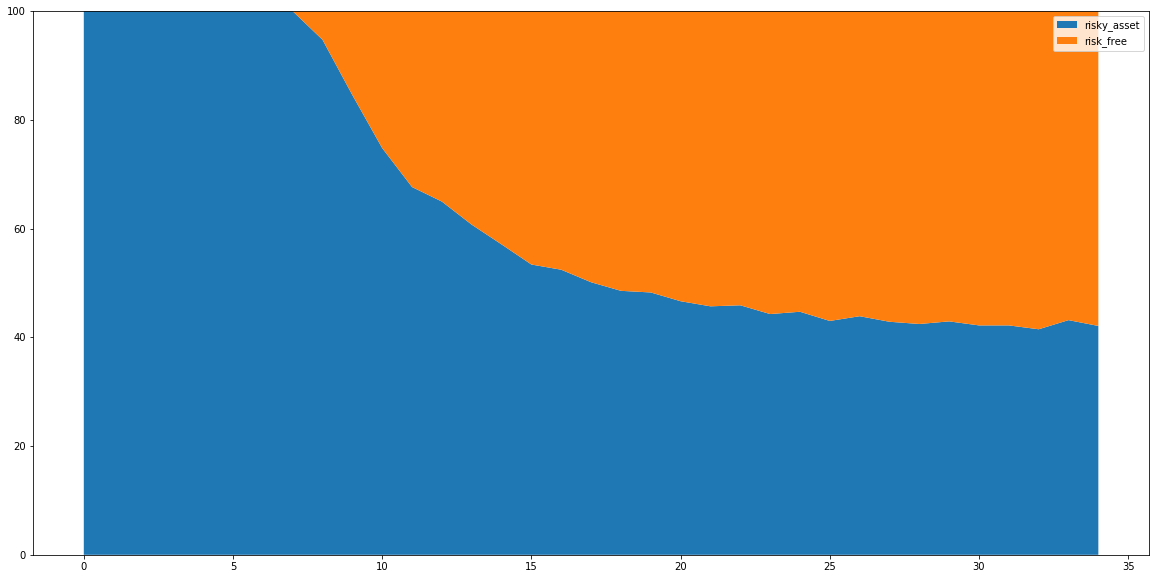

In [83]:
np.random.seed(30)

lc_weights = []
model = Maximize_Calibraton(n=20000, rho=-0.010961, gamma=4, aggregate_risk=np.sqrt(0.141262+0.005379))
for i in range(35)[::-1]:
    
    if i is range(35)[::-1][0]:
        financial_wealth = 7000
        income = np.exp(7.8717-2.3055+0.3841+0.0440*2 + 25 * 0.1055 + ((25**2 /10) *-0.0111) + ((25**3/100) * 0.0001))
        model.change_parameters(i, financial_wealth, income)
    else:
        financial_wealth = (model.initial_wealth + np.mean(model.labor_income[:, 0]) * 0.3) * np.mean(model.R_t @ model.fit())
        income = np.mean(model.labor_income[:, 0])
        model.change_parameters(i, financial_wealth, income)

    model.MC_data()
    model.get_calibration_H(fixed_effect_coeff=[7.8717-0.7417+0.3841+0.0440*2], age_coeff_list=[0.1055, -0.0111, 0.0001])
    model.get_asset_ret(market_mu=0.12, market_sigma=0.35, rf_mu=0.04, rf_sigma=0.03)
    opt_weights = model.fit()
    lc_weights.append(opt_weights)
    print(model.period, opt_weights * 100, np.round(financial_wealth), np.round(income))
    #print(model.period, model.fit() * 100, np.round(model.initial_wealth), np.round(np.mean(model.labor_income[:, 0])))

lc_df = pd.DataFrame(lc_weights, columns=["risky_asset", "risk_free"]) * 100

plt.figure(figsize=(20, 10))
plt.fill_between(lc_df.index, lc_df["risky_asset"])
plt.fill_between(lc_df.index, lc_df["risky_asset"], 100)
plt.legend(["risky_asset", "risk_free"])
plt.ylim(0, 100)
plt.show()

34 [100.   0.] 7000 2974.0
33 [100.   0.] 14756.0 15278.0
32 [100.   0.] 24980.0 16077.0
31 [100.   0.] 38284.0 16896.0
30 [100.   0.] 55567.0 17690.0
29 [100.   0.] 77885.0 18513.0
28 [100.   0.] 106625.0 19328.0
27 [100.   0.] 143602.0 20113.0
26 [96.  4.] 190999.0 20919.0
25 [83.07 16.93] 249985.0 21671.0
24 [75.13 24.87] 316950.0 22441.0
23 [68.16 31.84] 394249.0 23185.0
22 [63.63 36.37] 481405.0 23874.0
21 [59.6 40.4] 581283.0 24584.0
20 [56.98 43.02] 694780.0 25218.0
19 [54.17 45.83] 825097.0 25842.0
18 [52.21 47.79] 972805.0 26453.0
17 [50.43 49.57] 1141043.0 27043.0
16 [48.94 51.06] 1331997.0 27518.0
15 [47.68 52.32] 1548523.0 27967.0
14 [46.79 53.21] 1794309.0 28389.0
13 [46.04 53.96] 2074572.0 28739.0
12 [45.19 54.81] 2394203.0 29030.0
11 [44.39 55.61] 2756297.0 29325.0
10 [44. 56.] 3164871.0 29450.0
9 [43.52 56.48] 3629826.0 29637.0
8 [43.17 56.83] 4159856.0 29753.0
7 [42.76 57.24] 4761093.0 29774.0
6 [42.46 57.54] 5444436.0 29780.0
5 [42.31 57.69] 6220877.0 29665.0
4 [42.12

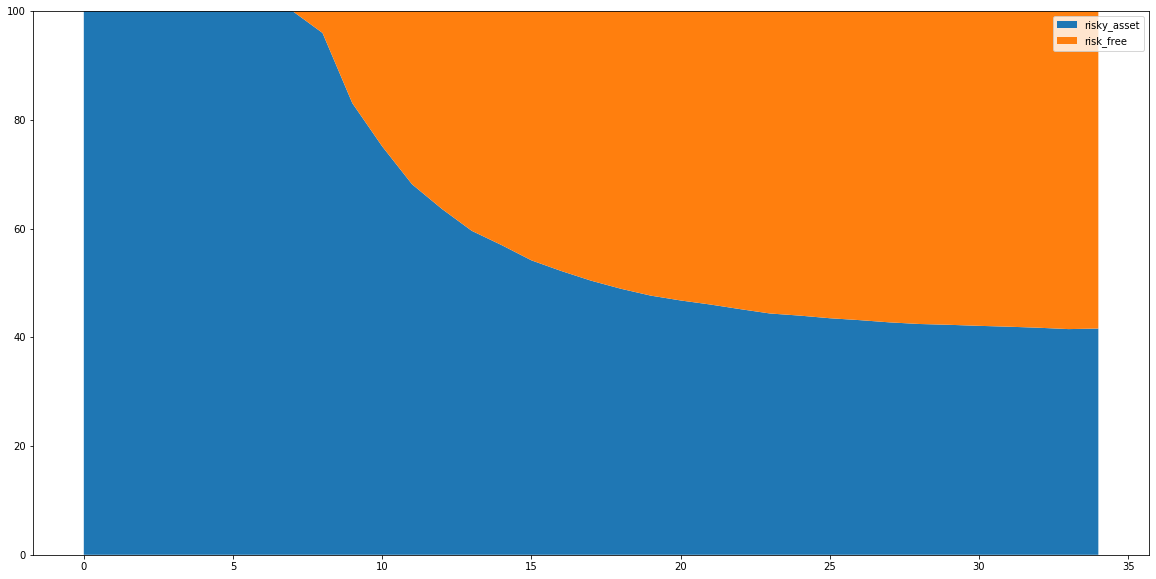

In [26]:
np.random.seed(30)

lc_weights = []
model = Maximize_Calibraton(n=500000, rho=-0.010961, gamma=4, aggregate_risk=np.sqrt(0.141262+0.005379))
for i in range(35)[::-1]:
    
    if i is range(35)[::-1][0]:
        financial_wealth = 7000
        income = np.exp(7.8717-2.3055+0.3841+0.0440*2 + 25 * 0.1055 + ((25**2 /10) *-0.0111) + ((25**3/100) * 0.0001))
        model.change_parameters(i, financial_wealth, income)
    else:
        financial_wealth = (model.initial_wealth + np.mean(model.labor_income[:, 0]) * 0.3) * np.mean(model.R_t @ model.fit())
        income = np.mean(model.labor_income[:, 0])
        model.change_parameters(i, financial_wealth, income)

    model.MC_data()
    model.get_calibration_H(fixed_effect_coeff=[7.8717-0.7417+0.3841+0.0440*2], age_coeff_list=[0.1055, -0.0111, 0.0001])
    model.get_asset_ret(market_mu=0.12, market_sigma=0.35, rf_mu=0.04, rf_sigma=0.03)
    opt_weights = model.fit()
    lc_weights.append(opt_weights)
    print(model.period, opt_weights * 100, np.round(financial_wealth), np.round(income))
    #print(model.period, model.fit() * 100, np.round(model.initial_wealth), np.round(np.mean(model.labor_income[:, 0])))

lc_df = pd.DataFrame(lc_weights, columns=["risky_asset", "risk_free"]) * 100

plt.figure(figsize=(20, 10))
plt.fill_between(lc_df.index, lc_df["risky_asset"])
plt.fill_between(lc_df.index, lc_df["risky_asset"], 100)
plt.legend(["risky_asset", "risk_free"])
plt.ylim(0, 100)
plt.show()

In [27]:
np.log(28452.0)

10.255973735853406